In [4]:
import platform
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from gensim.models import Word2Vec

In [18]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'
        self.df['therapy_Morps'] = self.df['therapy'].map(lambda x: self.getMorps(x))
        self.df['therapy_NV'] = self.df['therapy_Morps'].map(lambda x: self.getNV(x))
        self.df['therapy_N'] = self.df['therapy_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df['therapy_count_topn_NV']  = self.df['therapy_NV'].map(lambda x: self.counter(x,n)) 
        self.df['therapy_count_topn_N']  = self.df['therapy_N'].map(lambda x: self.counter(x,n)) 

    def result(self,idx, top , dis):
        effs_dims = ['에너지', '회복', '순환', '정화']
        sNV = self.df['therapy'][idx]
        result = []
        for dim in effs_dims:
            sub = []
            for sim_word in dim:
                for word in sNV:
                    try:
                        sub.append(self.wiki_model.wv.similarity(sim_word , word))
                    except:
                        sub.append(0)
            tmp = np.sort(sub)[::-1][:top].mean()
            result.append(tmp)

        
        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]

            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 대표어')
            plt.xticks(np.arange(len(effs_dims)), effs_dims)
            plt.yticks(np.arange(0,1.2,0.2))
            plt.show()
        return result
        

    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, emotion_idx,figsize):
        plt.rc('font', family=self.font)
        sNV = self.df['therapy'][emotion_idx]
        sNV = sNV.split(" ")
        effs_dims = ['에너지', '회복', '순환', '정화']
        
        
        result = []
        for out_word in sNV:
            sub_result = []
            for in_word in effs_dims:
                try:
                    sub_result.append(self.wiki_model.wv.similarity(out_word, in_word))
                except:
                    sub_result.append(0)
            result.append(sub_result)
        
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        plt.title(f'{emotion_idx}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(effs_dims)),effs_dims)
        plt.yticks(np.arange(len(sNV)),sNV)
        plt.show()
            
        
    def getDF(self):
        self.df.to_csv('data.csv')
        return self.df

    def count_to_csv(self,file_name):
        em_name = ['행복' , '열정' , '두려움', '분노' , '우울' , '슬픔']
        em_idx = []
        for em in em_name:
            em_idx.append(em)
            em_idx.append(em + "count")
            em_idx.append(em + 'sims')
        
        em_dict = []
        max =  0
        for idx in range(0,5):
            vv = len(collections.Counter(self.df['therapy_NV'][idx]).items())
            if max < vv:
                max = vv

        ret_df = pd.DataFrame(em_dict,columns=em_idx)
        
        for idx in range(0,len(em_idx),3):
            tmp = sorted(collections.Counter(self.df['therapy_NV'][round(idx/3)]).items(), key = lambda item : item[1], reverse=True)
            tmp_words = []
            tmp_counts = []
            tmp_sims = []
            for x, y in tmp:
                tmp_words.append(x)
                tmp_counts.append(y)
                try:
                    tmp_sims.append(self.wiki_model.wv.similarity(x,em_idx[idx]))
                except:
                    tmp_sims.append(0)
            for _ in range(0,max - len(tmp)):
                tmp_words.append("")
                tmp_counts.append(0)
                tmp_sims.append(0)
                
            ret_df[em_idx[idx]] = tmp_words
            ret_df[em_idx[idx+1]] = tmp_counts
            ret_df[em_idx[idx+2]] = tmp_sims
        ret_df.to_csv(file_name)
        return ret_df
                
    def sim_word_to_csv(self,topn,file_name):
        em_name = ['행복','Similarity', '열정','Similarity', '두려움', 'Similarity', '분노','Similarity', '우울','Similarity', '슬픔','Similarity']
        em_dict = []
        
        ret_df = pd.DataFrame(em_dict,columns=em_name)
        for idx in range(0,len(em_name),2):
            
            tmp = self.wiki_model.wv.most_similar(em_name[idx],topn=topn)
            tmp_simwords = []
            tmp_Similarity = []
            
            for x , y in tmp:
                tmp_simwords.append(x)
                tmp_Similarity.append(y)
            
            ret_df[em_name[idx]] = tmp_simwords
            ret_df[em_name[idx+1]] = tmp_Similarity
        ret_df.to_csv(file_name)
        return ret_df
    
    def todf(self,file_name):
        ret_df  = pd.DataFrame(columns=['감정','에너지','회복','순환','정화'])
        em = []
        est_e= []
        est_h= []
        est_c= []
        est_p= []
        
        cols = self.df.columns
        for idx in self.df.index:
            em.append(self.df['emotion'][idx])
            est = self.result(idx,5,False)
            est_e.append(est[0])        
            est_h.append(est[1])        
            est_c.append(est[2])        
            est_p.append(est[3])
        ret_df['감정'] = em        
        ret_df['에너지'] = est_e
        ret_df['회복'] = est_h
        ret_df['순환'] = est_c
        ret_df['정화'] = est_p
        
        ret_df.to_csv(file_name,index=False)
        return ret_df

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


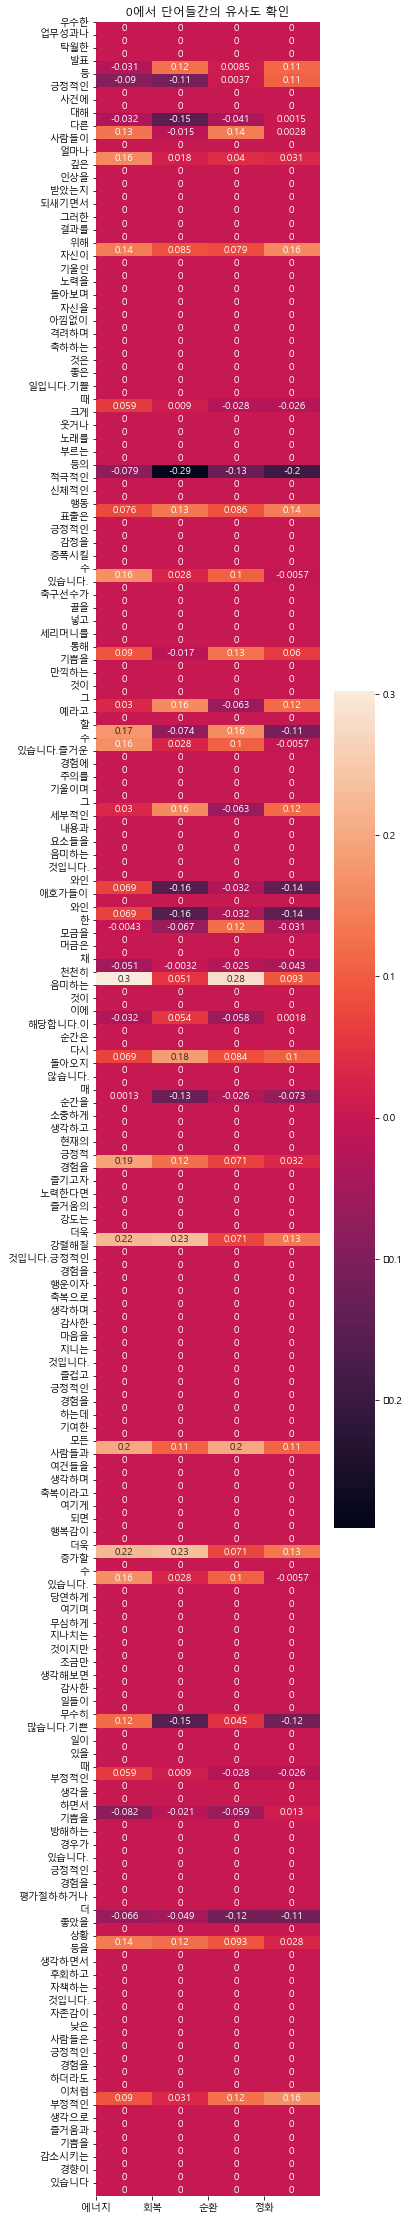

In [20]:
XYZ = check_data(data)
XYZ.get_heatmap(0,(5,40))

In [6]:
data = pd.read_csv("../data/emotion_data.csv")
data

,emotion,therapy
0,행복,우수한 업무성과나 탁월한 발표 등 긍정적인 사건에 대해 다른 사람들이 얼마나 깊은 ...
1,열정,어쩌면 무책임한말. 세상에는 열정으로 되는 것이 있고 되지 않는 것이 있다. 열정은...
2,두려움,우리에게 두려움을 일으키는 요인은 다양하다. 엘리베이터에 타는 것을 꺼리는 사람이 ...
3,분노,"뇌와 호르몬이 작동하는 원리에 따라 내면을 들여다보면 내 안의 분노와 열등감, 자기..."
4,우울,"슬픔, 흥미의 상실, 무관심 이 세 가지는 많은 우울증 환자들을 둘러싼 어두운 삼각..."
5,슬픔,슬픔에는 정서적 증상과 신체적 증상이 있다는 점을 알고 있는 것이 좋다. 비탄을 겪...


In [4]:
XYZ = check_data(data)
XYZ.todf("../result/emotion_estimation.csv")

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


,감정,에너지,회복,순환,정화
0,행복,1.0,0.895547,0.664710,1.0
1,열정,1.0,0.883856,0.699461,1.0
2,두려움,1.0,1.000000,0.541071,1.0
3,분노,1.0,0.686641,0.460918,1.0
4,우울,1.0,0.895547,1.000000,1.0
5,슬픔,1.0,1.000000,0.541815,1.0


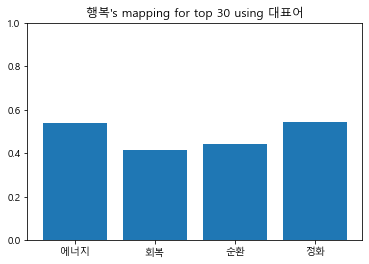

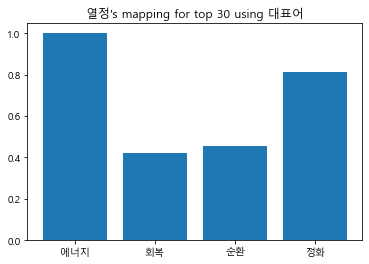

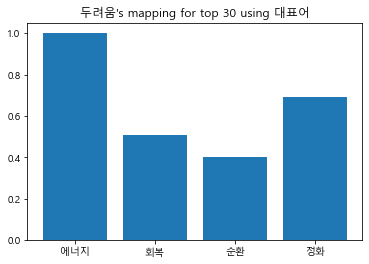

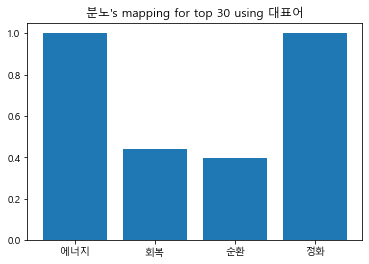

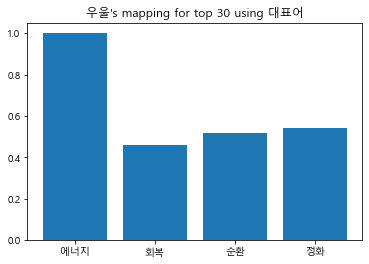

In [5]:
for idx in range(0,5):
    XYZ.result(idx,30,True)
    

In [23]:
h_data = pd.read_csv("../data/emotion_data_hand_craft.csv")
h_data

,emotion,therapy
0,행복,음미 향유 긍정 느낌 증폭 지속 만끽 자축 즐거움 감사
1,열정,열정 오래가다 지속 타오르다 유지 건강 목표 달리다 실행 힘 숙면 운동 계획 능률...
2,두려움,즐거움 호기심 긍정 진정
3,분노,잠재우다 호르몬 작동 내면 줄이다 멈추다 전환점 통제 비우다 회피 인정 치료 의식...
4,우울,긍정 회복 목표 운동 균형
5,슬픔,지원 건강 극복 행복


In [24]:
hXYZ = check_data(h_data)
hXYZ.todf("../result/emotion_estimation_hand_craft.csv")

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


,감정,에너지,회복,순환,정화
0,행복,0.441997,0.280129,0.329806,0.415003
1,열정,1.000000,0.456525,0.405685,1.000000
2,두려움,0.251791,0.277455,0.334114,0.536851
3,분노,0.566569,0.517889,0.520081,0.871676
4,우울,0.098494,0.594044,0.380115,0.387859
5,슬픔,0.291794,0.513508,0.353911,0.257016


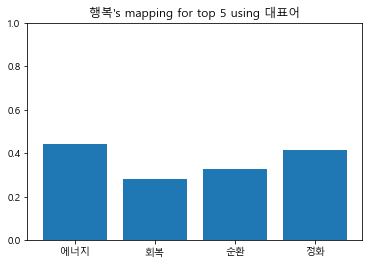

C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


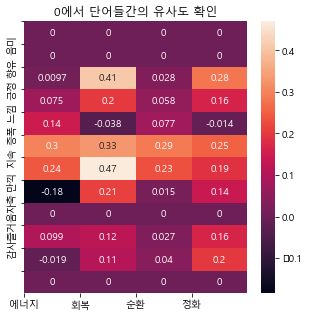

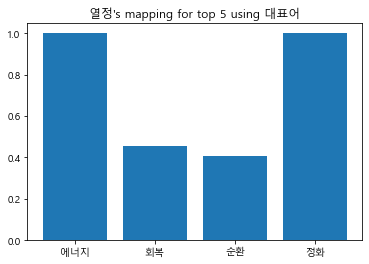

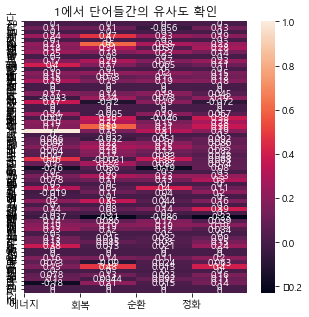

In [26]:
for i in range(0,2):
    hXYZ.result(i,5,True)
    hXYZ.get_heatmap(i,(5,5))